### 6.6 Sourcing & Analyzing Time-Series Data

#### 1. Importing libraries and data

In [15]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

In [16]:
# Configure API key

quandl.ApiConfig.api_key = '43pDY7h1GW-HsEcAVX49'

### Importing data for analysis

In [17]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment (* Short Term)" variable.

data = quandl.get('FRED/NROUST')

In [18]:
# Checking the data

data.head()

,Value
Date,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


In [19]:
data.shape

(332, 1)

In [20]:
data.columns

Index(['Value'], dtype='object')

In [21]:
type(data)

pandas.core.frame.DataFrame

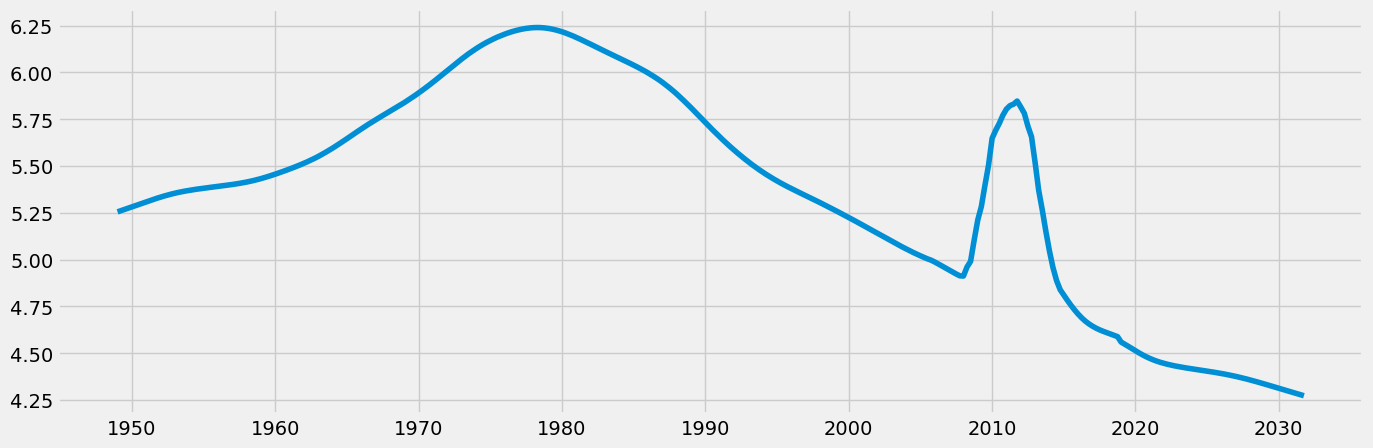

In [22]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. 
# When it's set to 100, it will produce lower-than-standard quality, which is useful if, similar to this notebook, 
# you'll have a lot of plots. A large number of plots will increase the size of the notebook, 
# which could take more time to load and eat up a lot of RAM!

plt.plot(data)

In [23]:
# Checking for missing values (you shouldn't have any)

data.isnull().sum()

Value    0
dtype: int64

In [24]:
# Check for duplicates

dups = data.duplicated()
dups.sum()  

# No dups!

0

#### 2. Subsetting, wrangling, and cleaning time-series data

In [27]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [28]:
data_2.head()

,Date,Value
0,1949-01-01,5.255053
1,1949-04-01,5.261516
2,1949-07-01,5.268013
3,1949-10-01,5.274564
4,1950-01-01,5.281182


In [30]:
# Producing a subset for data from 1990 until February of 2021.
# Website says data set has been refreshed on February 1st, 2021.
# I only used historic data and excluded forecasted data.

data_sub = data_2.loc[(data_2['Date'] >= '1990-01-01') & (data_2['Date'] < '2021-02-01')]

In [31]:
data_sub.shape

(125, 2)

In [32]:
data_sub.head()

,Date,Value
164,1990-01-01,5.732765
165,1990-04-01,5.713231
166,1990-07-01,5.693902
167,1990-10-01,5.674851
168,1991-01-01,5.656146


In [33]:
data_sub.tail()

,Date,Value
284,2020-01-01,4.512876
285,2020-04-01,4.501435
286,2020-07-01,4.490658
287,2020-10-01,4.480756
288,2021-01-01,4.471833


In [34]:
# Setting the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date'])  # Create a datetime column from "Date"
data_sub = data_sub.set_index('datetime')                # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True)            # Drop the "Date" column.
data_sub.head() 



,Value
datetime,
1990-01-01,5.732765
1990-04-01,5.713231
1990-07-01,5.693902
1990-10-01,5.674851
1991-01-01,5.656146


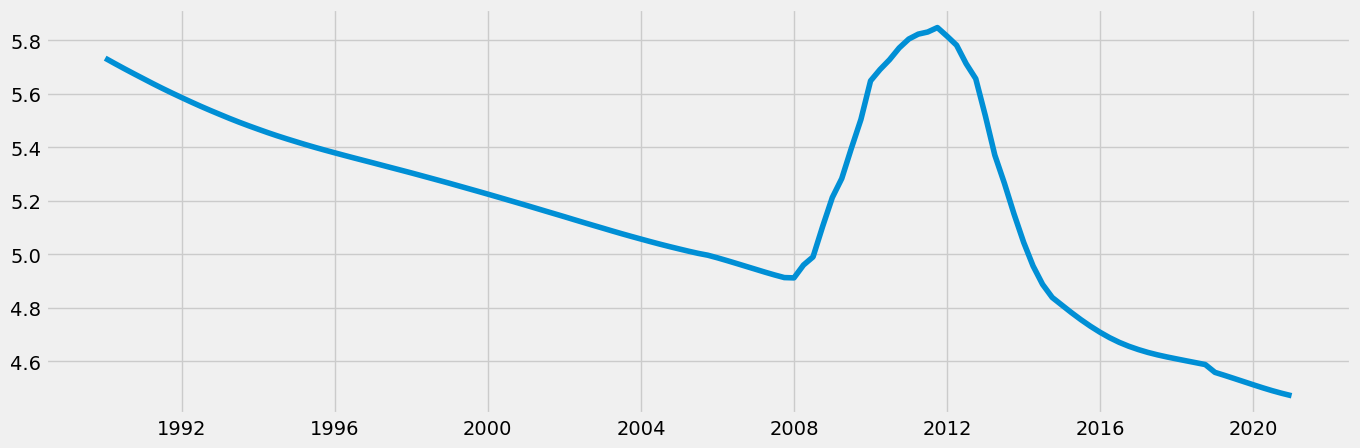

In [35]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

### 3. Time-series analysis: decomposition

In [40]:
# Decomposing the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [41]:
from pylab import rcParams  # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18,7

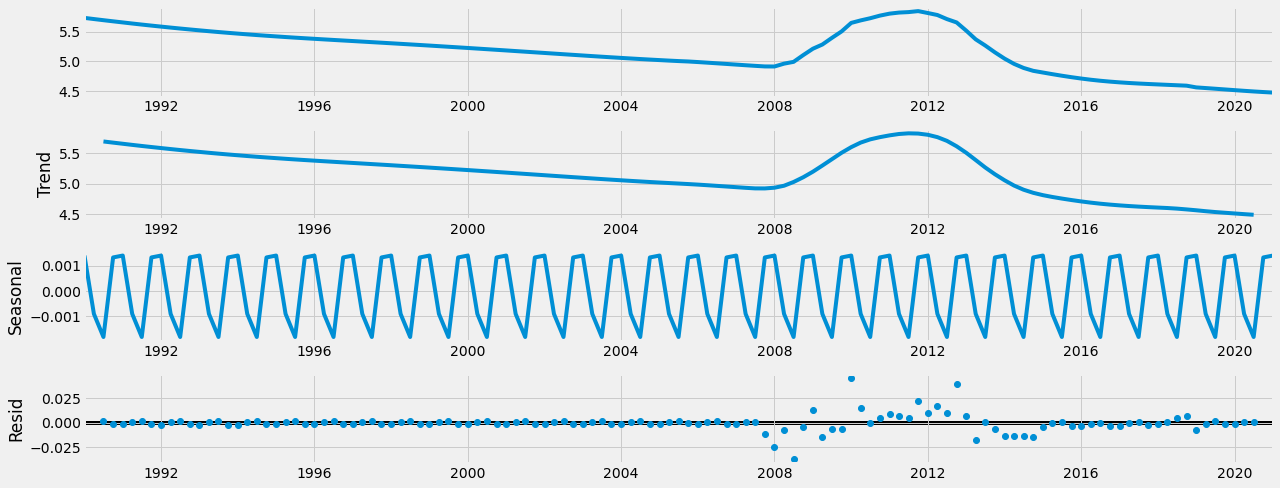

In [42]:
# Plot the seperate components

decomposition.plot()
plt.show()

The first chart in the figure above is the data itself (including all of its components). This is called the level. The second is underlying trend. The level and underlying trend appear the almost same so that the data does not much noise. 
The trend in the chart aboved gradually drops after 1990 and jumped around 2009, likely due to the global financial crisis, the overall trend continous to decrease all the way until now. 
The seasonal line shows that the data shows seasonality effects may related to seasonal jobs.

#### 4. Testing for stationarity

In [44]:
# The adfuller() function will import from the model from statsmodels for the test; however, 
# running it will only return an array of numbers. 
# This is the resaon to define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.572357
p-value                          0.877107
Number of Lags Used             12.000000
Number of Observations Used    112.000000
Critical Value (1%)             -3.490131
Critical Value (5%)             -2.887712
Critical Value (10%)            -2.580730
dtype: float64


In order to determine the results of a statistical hypothesis test, one has to compare the **test statistic** to the **critical value** of the corresponding significance level. 

If the **test statistic** is larger than the **critical value**, one can’t reject the null hypothesis. 
If the **test statistic** is smaller than the **critical value**, the null hypothesis could be rejected. 

In this case, considering a significance level of 5%, the “Critical Value of 5% has a value of -2.887712. This is smaller than the **test statistic**, which is -0.572357, which means that the null hypothesis cannot be rejected.

This also means that there is a unit root in our data and the data is non-stationary.

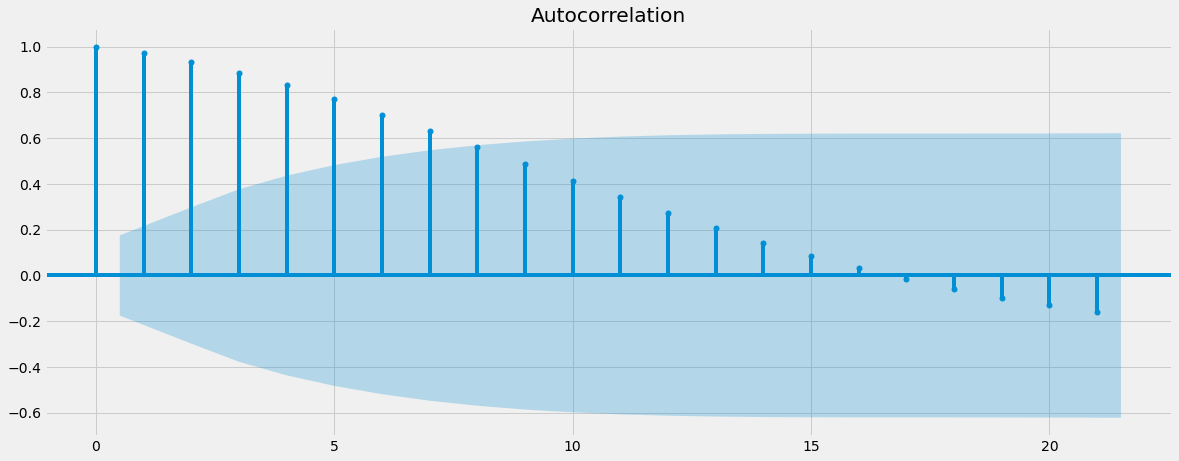

In [46]:
# Checking out autocorrelations with a plot

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Import autocorrelation and partial correlation plots. 

plot_acf(data_sub)
plt.show()


The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means there are lags which are significantly correlated with each other. 
In the chart aboved, there are many lags beyond the blue interval, so it can be deduced that the data is non-stationary.

#### 5. Stationarizing the data 

In [47]:
data_diff = data_sub - data_sub.shift(1)     # The df.shift(1) function turns the observation to t-1, 

# making the whole data t - (t-1)

In [48]:
data_diff.dropna(inplace=True)  # Missing values that came about as a result of the differencing are removed.
# They need to be removed or the Dickey-Fuller test won't run.

In [49]:
data_diff.head()

,Value
datetime,
1990-04-01,-0.019534
1990-07-01,-0.019328
1990-10-01,-0.019051
1991-01-01,-0.018706
1991-04-01,-0.018308


In [50]:
data_diff.tail()

,Value
datetime,
2020-01-01,-0.011806
2020-04-01,-0.011441
2020-07-01,-0.010777
2020-10-01,-0.009902
2021-01-01,-0.008923


In [51]:
data_diff.columns

Index(['Value'], dtype='object')

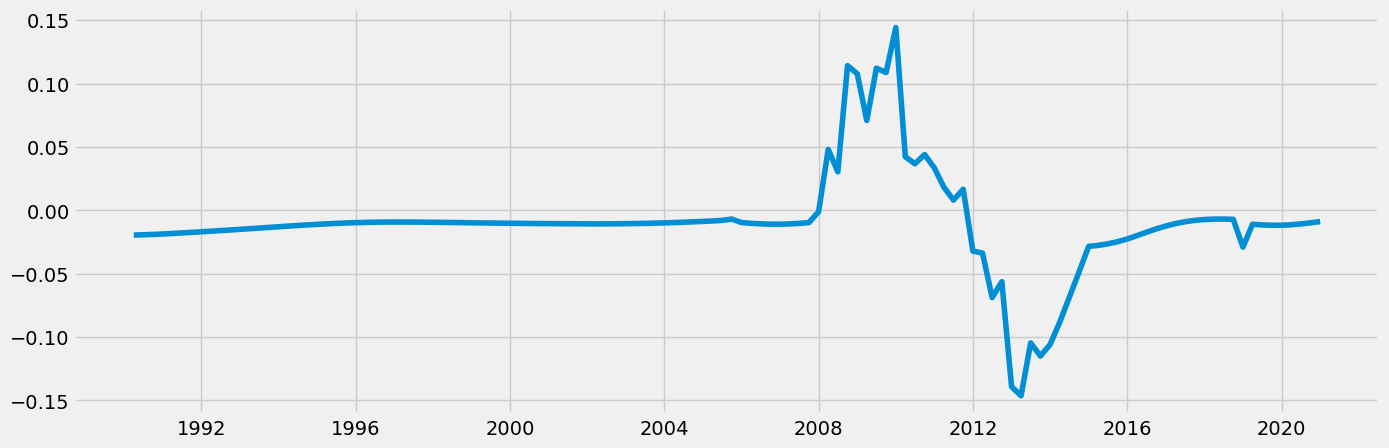

In [52]:
# Checking out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

As a result of stationarizing method, the data effectively getting rid of the trend. The trend was giving to the data a downward slope.
So, without it, the visual have a much more horizontal line. 

In [53]:
# Running the Dickey-Fuller Test again

dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.076636
p-value                          0.001058
Number of Lags Used             11.000000
Number of Observations Used    112.000000
Critical Value (1%)             -3.490131
Critical Value (5%)             -2.887712
Critical Value (10%)            -2.580730
dtype: float64


Test statistcis is now smaller than the critical value at all percent significance levels. 
The result means that it is possible to reject the null hypothesis and, as a result, consider the series stationary.

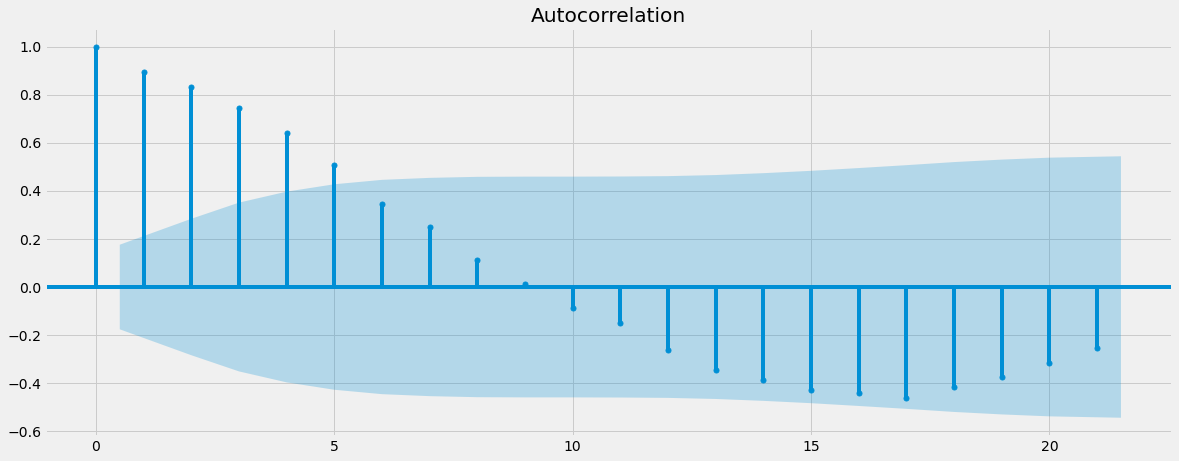

In [54]:
# Plotting the autocorrelation again

plot_acf(data_diff)
plt.show()